### SEG Geophysical Tutorial
# Coloured inversion

[**Martin Blouin**](mailto:martin.blouin@geolearn.ca) — GeoLEARN Solutions, Quebec City, Canada

**Erwan Gloaguen** — INRS-ETE, Quebec City, Canada

<hr />

In this tutorial, we implement a simple version of the coloured inversion algorithm proposed by Lancaster et Whitcombe (2000) in Python.

We use the F3 dataset from the Netherlands. The dataset is owned by the government of the Netherlands / TNO and licensed CC-BY-SA by TNO / dGB Earth Sciences. You can get the data from [the Open Seismic Repository](https://www.opendtect.org/osr/pmwiki.php/Main/NetherlandsOffshoreF3BlockComplete4GB). 

### Preliminaries

In [1]:
import os

# For plotting and numerics.
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# For LAS loading and data management.
import lasio
import pandas as pd

### The dataset
For this example, we use the dGB Earth Sciences, OpendTect F3 Dataset from which we recovered one well AI log and a vertical seismic 2D panel collocated with the F02-1 well log. There is also an AI cube that was apparently (info received by Matt from a dGB employee) generated with a commercial software using a model-based constrained inversion with hard constraints.

Let's display a section of this AI cube to get an idea of where we want to get with our workflow.

In [2]:
win_up = 408
win_down = 1136
time_IP = np.arange(win_up, win_down+1, 4)  # Time window of cube in OpendTect project.
IP_section = np.loadtxt('data/Ai_inline362_horizons.dat')
panel_IP = (IP_section[:, 2:]).T
xbin = (IP_section[:, 1])

We will put the IP panel in a `pandas` DataFrame to plot without the NaNs using `imshow`.

In [3]:
xi, ti = np.meshgrid(xbin, time_IP)

In [4]:
IP_section = pd.DataFrame()
IP_section['X'] = xi.ravel()
IP_section['t'] = ti.ravel()
IP_section['IP_open'] = panel_IP.ravel()
IP_section.replace(1e30, np.nan, inplace=True)  # 1e30 are NaN in project.
id_nan = IP_section.IP_open.isnull()  # This will be useful later to plot our result with the same shape.
IP_section = IP_section.set_index(['X', 't'])
IP_section = IP_section.unstack(level='X')

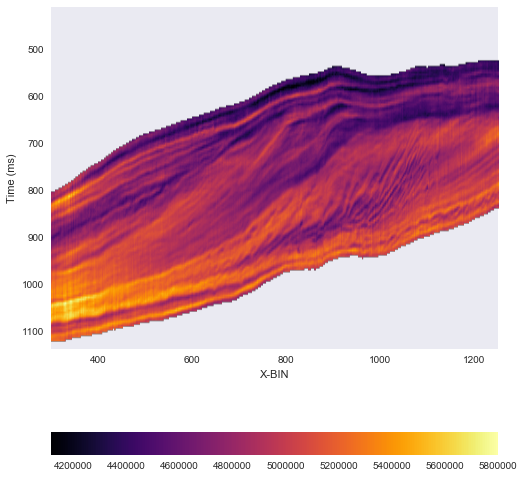

In [5]:
with sns.axes_style("dark"):
    fig, (ax) = plt.subplots(figsize=(8, 10))
    extent = [np.min(xbin), np.max(xbin), np.max(time_IP), np.min(time_IP)]
    image = ax.imshow(IP_section.IP_open, extent=extent, cmap='inferno')
    ax.axis([np.min(xbin), np.max(xbin), np.max(time_IP), np.min(time_IP)])
    ax.set_xlabel('X-BIN')
    ax.set_ylabel('Time (ms)')
    cbar = plt.colorbar(image, orientation='horizontal')
    plt.show()

Some code to extract top and bottom horizon. This will prove to be useful later to plot and compare...

In [6]:
top = [time_IP[np.where(panel_IP[:,col]<1e30)[0][0]-1] for col in range(panel_IP.shape[1])]
bot = [time_IP[np.where(panel_IP[:,col]<1e30)[0][-1]+1] for col in range(panel_IP.shape[1])]

## The workflow

1.	Fit a function to the well log power spectrum
2.	Get difference spectrum by substracting the seismic power spectrum from it
3.	Convert the difference spectrum to an operator
4.	Convolute the stacked seismic with the operator
5.	QC – check the residuals by comparing log and AI section power spectrum

Using the `lasio` library, we start by reading all the logs of the F3 project:

In [7]:
import glob

Logs = pd.DataFrame()
temp = pd.DataFrame()

las_files = glob.glob("data/All_wells_RawData/Lasfiles/*.las")
for i, las in enumerate(las_files):
    well = lasio.read(las,encoding='utf-8')
    logs_param = []
    temp = pd.DataFrame()
    for curve in well.curves:
        try:
            temp['ID'] = os.path.basename(las)[:5]
            temp[curve.mnemonic] = well[curve.mnemonic]
        except:
            pass
    if i == 0:   
        Logs = temp.copy()
    else:
        Logs = pd.concat([Logs,temp], axis=0)

In [8]:
Logs.head()

,ID,DEPTH,RHOB,DT,GR,AI,AI_rel,PHIE
0,F02-1,48.00,NaN,524.0485,NaN,3820257.00,-455.6956,NaN
1,F02-1,48.15,NaN,524.0410,NaN,3820311.75,-455.6956,NaN
2,F02-1,48.30,NaN,524.0336,NaN,3820366.25,-455.6956,NaN
3,F02-1,48.45,NaN,524.0262,NaN,3820419.75,-455.6956,NaN
4,F02-1,48.60,NaN,524.0190,NaN,3820472.25,-455.6956,NaN


We start by looking at only one IP log collocated with the seismic data 2D section we are planning to use (F02-1).

For convenience, we just keep AI and depth as seperate arrays from the grouped DataFrame

In [9]:
grouped = Logs.groupby('ID')
AI_f021 = (grouped.get_group('F02-1').AI).values
depth_f021 = (grouped.get_group('F02-1').DEPTH).values

Let's plot the AI log in F02-1 as a function of depth to see what it looks like:

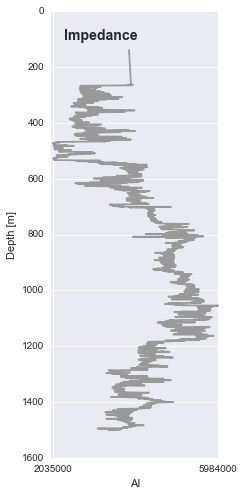

In [10]:
color_list = ['#999999','#2166ac','#b2182b']
my_palette = sns.color_palette(color_list)
sns.set_palette(my_palette)
fig,ax1 = plt.subplots(figsize=(3, 8))

ax1.plot(AI_f021[600:], depth_f021[600:])
ax1.text(2300000, 100, 'Impedance', fontsize=14, fontweight='semibold')
ax1.set_xlabel('AI')
ax1.set_ylabel('Depth [m]')
ax1.invert_yaxis()
ax1.set_xticks([np.floor(np.min(AI_f021)/1000)*1000,np.ceil(np.max(AI_f021)/1000)*1000]);

### Convert depth to time

Before working in the Fourier domain, we need to convert the log in the time domain. From the F3 project, we get the time-depth table as txt. Then we can make an interpolation function and apply it to the depth info:

In [11]:
TD = np.loadtxt('data/All_wells_RawData/DT_model/F02-1_TD.txt')

In [12]:
TD

array([[    0.    ,     0.    ],
       [  274.032 ,   279.7635],
       [  274.184 ,   279.9148],
       ..., 
       [ 1469.762 ,  1483.9602],
       [ 1469.915 ,  1484.1241],
       [ 3120.    ,  3258.8857]])

Using scipy.interpolate to simply interpolate linearly the time-depth function:

In [13]:
from scipy.interpolate import interp1d
f_td = interp1d(TD[:,1], TD[:,0], kind='linear')
time_f021 = f_td(depth_f021)

Now we generate the power spectrum in the Fourier domain:

In [14]:
n_log = AI_f021.shape[0]  # Number of samples.
k_log = np.arange(n_log-1)
Fs_log = 1 / np.diff(time_f021/1000)  # Getting sampled frequencies.
T_log = n_log / Fs_log
freq_log = k_log / T_log
freq_log = freq_log[range(n_log//2)]  # One side frequency range.
spec_log = np.fft.fft(AI_f021) / n_log  # FFT computing and normalization.
spec_log = spec_log[range(n_log//2)]

And plot AI log along with the power spectrum:

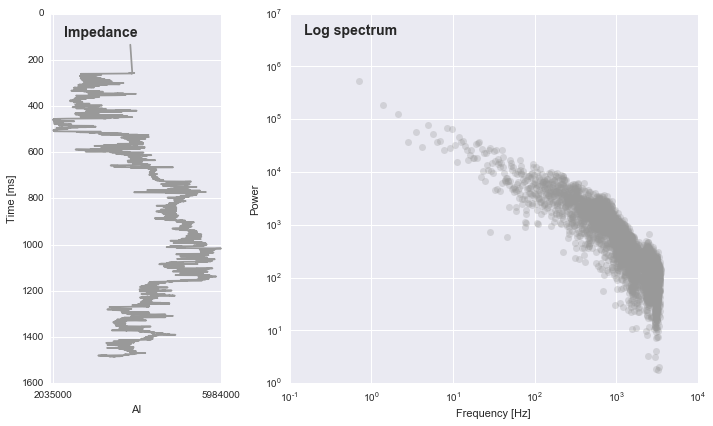

In [15]:
# Set up.
color_list = ['#999999', '#2166ac', '#b2182b']
my_palette = sns.color_palette(color_list)
sns.set_palette(my_palette)
fig = plt.figure(figsize=(10, 6))
ax1 = plt.subplot2grid((1,3), (0,0))
ax2 = plt.subplot2grid((1,3), (0,1), colspan=3)

# Well log.
ax1.plot(AI_f021[600:], time_f021[600:])
ax1.text(2300000,100,'Impedance', fontsize=14, fontweight='semibold')
ax1.set_xlabel('AI')
ax1.set_ylabel('Time [ms]')
ax1.invert_yaxis()
ax1.set_xticks([np.floor(np.min(AI_f021)/1000)*1000, np.ceil(np.max(AI_f021)/1000)*1000])

# Crossplot.
ax2.set_ylabel('Power')
ax2.set_xlabel('Frequency [Hz]')
ax2.plot(freq_log, np.abs(spec_log), 'o', alpha=0.3)
ax2.text(0.15,4e6, 'Log spectrum', fontsize=14, fontweight='semibold')
ax2.set_yscale('log')
ax2.set_xscale('log')

# Finish up.
fig.tight_layout()
plt.show()

### Seismic data

One last thing: in order to generate an relative AI section, we need a stacked seismic section.

In [16]:
data_read = np.loadtxt('data/export_inline362.ascii')  # This ascii panel from F3 was exported using OpendTect.
panel_seis = (data_read[:, 2:]).T
time = np.arange(0, 1852, 4)  # Time sampling of the seismic data.

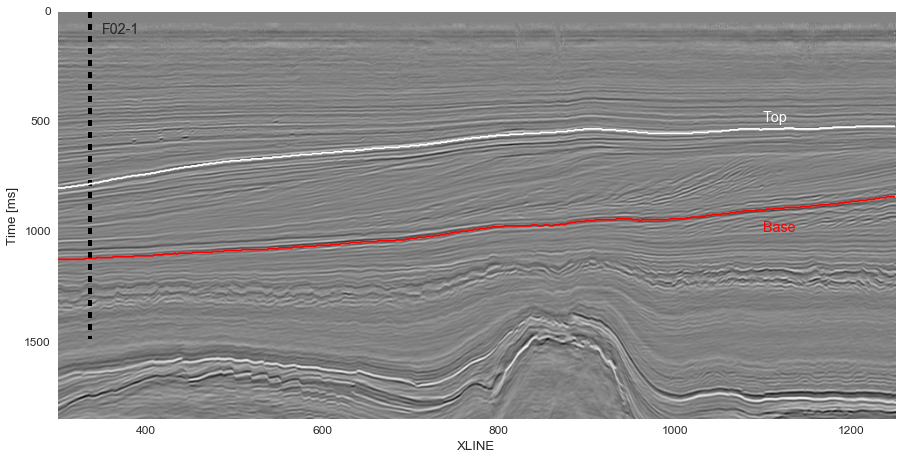

In [17]:
sns.set(font_scale=1.2)
sns.set_palette(my_palette)

with sns.axes_style("dark"): 
    fig,(ax) = plt.subplots(figsize=(15,10))

extent = [np.min(xbin),np.max(xbin),np.max(time),np.min(time)]
ax.imshow(panel_seis, extent=extent, aspect=0.25, cmap='Greys', label='big')
ax.plot([336,336], [0, np.max(time_f021)], 'k--', lw=4)  # Just to display the well position.
ax.plot(xbin, top, 'w')
ax.plot(xbin, bot, 'r')
ax.text(350, 100, 'F02-1')
ax.text(1100, 500, 'Top', color='w')
ax.text(1100, 1000, 'Base', color='r')

ax.set_ylim(np.max(time), np.min(time))
ax.set_xlim(np.min(xbin), np.max(xbin))
ax.set_xlabel('XLINE')
ax.set_ylabel('Time [ms]')

plt.show()

## Step 1: Fit a function

We can now approximate the well log AI power spectrum by a continuous function. We use a simple linear model (in log scale) with a negative slope. Simple considerations to achieve it:

1. Creation of a function representing the model
2. Defining an objective function
3. We use scipy.optimize library
4. Least square approach

In [18]:
def linearize(p, x):
    return p[0] * x**p[1]   

In [19]:
def error(p, x, y):    
    return (np.log10(y) - np.log10(linearize(p, x)))

We define our regression not over the entire data length, only fitting the first 2000 frequencies of the spectrum. This is a user choice that will influence our end result. Since the element at spec[2000] is a frequency of around 1500 Hz, we figure our model doesn't need to fit log frequencies beyond that.

In [20]:
from scipy import optimize

args = freq_log[1:2000], np.abs(spec_log[1:2000])
qout, success = optimize.leastsq(error,
                                 [1e5,-0.8],
                                 args=args,
                                 maxfev=3000)

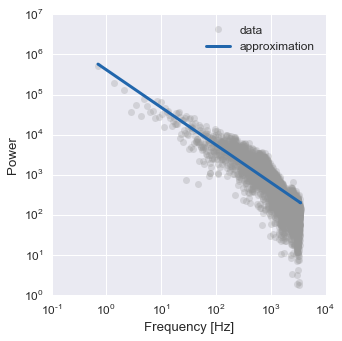

In [21]:
fig,ax1=plt.subplots(figsize=(5,5))

spec = ax1.plot(freq_log,np.abs(spec_log), 'o', alpha=0.3)
approx = ax1.plot(freq_log[1:], linearize(qout, freq_log[1:]), linewidth=3)
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_ylabel('Power')
ax1.set_xlabel('Frequency [Hz]')
plt.legend(['data', 'approximation'], loc='best')
fig.tight_layout()

We now need to calculate the seismic power spectrum around the well location:

1. We calculate a mean trace
2. We do the Fourier transform

The mean is calculated usign a user-defined window both for time and the number of seismic traces

In [22]:
min_time = 50
max_time = 250
xmin = 26
xmax = 46
trace = np.mean(panel_seis[min_time:max_time, xmin:xmax], axis=1)

We repeat the procedure to calculate the power spectrum:

In [23]:
Fs_seis = 1 / 0.004  # Seconds.
n_seis = len(trace)
k_seis = np.arange(n_seis)
T_seis = n_seis / Fs_seis
freq_seis = k_seis / T_seis
freq_seis = freq_seis[range(n_seis//2)]  # One side frequency range.

spec_seis = np.fft.fft(trace) / n_seis  # FFT computing and normalization.
spec_seis = spec_seis[range(n_seis//2)]

# This is to smooth the spectrum over a window of 10.
roll_win = np.ones(10) / 10
spec_seis = np.convolve(spec_seis, roll_win, mode='same')

And plot the mean seismic trace with the spectrum:

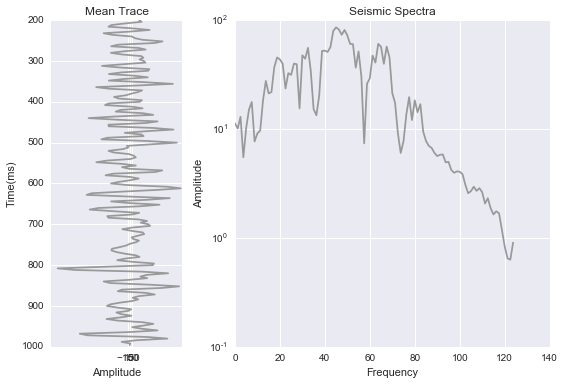

In [24]:
sns.set(font_scale=1)
sns.set_palette(my_palette)
fig = plt.figure()
ax1 = plt.subplot2grid((1,3), (0,0))
ax2 = plt.subplot2grid((1,3), (0,1), colspan=2)

ax1.plot(trace,time[min_time:max_time])
ax1.set_xlabel('Amplitude')
ax1.set_ylabel('Time(ms)')
ax1.invert_yaxis()
ax1.set_xticks([-150, 0, 150])
ax1.set_title('Mean Trace')
#ax1.set_xlim([-300, 400])

ax2.set_ylabel('Amplitude')
ax2.set_xlabel('Frequency')
ax2.plot(freq_seis,np.abs(spec_seis))
ax2.set_title('Seismic Spectra')
ax2.set_yscale('log')
#ax2.set_xlim([0, 200])
#ax2.set_ylim([0.1, 50])

fig.tight_layout()
plt.show()

We now compare seismic spectrum with the one from the AI log.

We adjust the modelled log AI power spectrum to definied frequency boundaries with a taper.

In [25]:
spec_seis = spec_seis * 100  #Since power spectrum is relative, we scale this one to compare to the log spectrum

x_tape_in = np.linspace(0, 5, 50)
x_tape_out = np.linspace(115, 125, 50)

y_tape_in = np.hanning(100)[:50] * linearize(qout, x_tape_in[-1])
y_tape_out = np.hanning(100)[50:] * linearize(qout, x_tape_out[0])

We limit our modelled frequency between 5 and 115Hz and append Hanning tapers at the begining (0-5Hz) and at the end (115-125 Hz)

In [26]:
id_seis = (freq_seis > 5) * (freq_seis < 115)
new_freq_log = np.hstack([x_tape_in, freq_seis[id_seis], x_tape_out])
new_spec_log = np.hstack([y_tape_in, linearize(qout, freq_seis[id_seis]), y_tape_out])

We plot the resulting power spectrum:

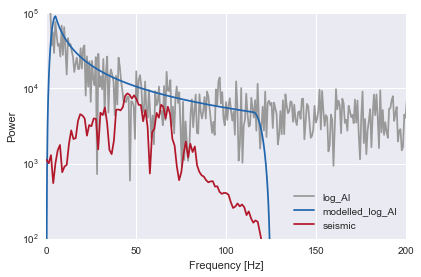

In [27]:
fig,ax = plt.subplots(figsize=(6,4))
ax.plot(freq_log,np.abs((spec_log)))
ax.plot(new_freq_log,new_spec_log)
ax.set_ylabel('Power')
ax.set_xlabel('Frequency [Hz]')
ax.plot(freq_seis, np.abs((spec_seis)))
ax.set_yscale('log')
ax.set_xlim([0, 200])
ax.set_ylim([100, 100000])
plt.legend(['log_AI', 'modelled_log_AI', 'seismic'], loc='best')
plt.tight_layout()
plt.show()

## Step 2. Get difference spectrum

We can now calculate the difference spectra and the resulting operator

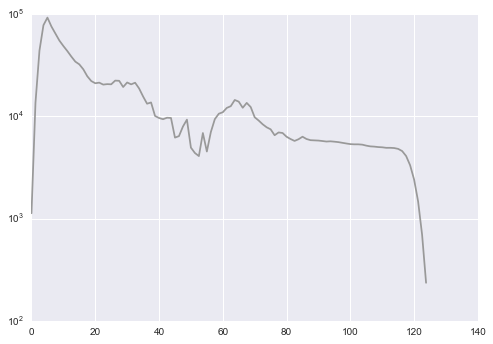

In [28]:
f_log = interp1d(new_freq_log, new_spec_log, bounds_error=False, fill_value=0)
spec_log_seis_sample = f_log(freq_seis)
gap = (spec_log_seis_sample - spec_seis)

# Quick plot to check it.
plt.plot(freq_seis, np.abs(gap))
plt.yscale('log')
plt.show()

## Step 3. Convert the difference spectrum to an operator

Use the inverse Fourier transform followed by a phase rotation to get an operator.

We define some intermediate steps to plot them later.

In [29]:
operator1 = np.fft.ifft(np.abs(gap))
operator2 = np.fft.fftshift(operator1)  # We move the operator to the center of the window.
operator  = operator2.imag  # We take the quadrature part (90deg) of the operator.

We plot the difference again, together with the resulting operator:

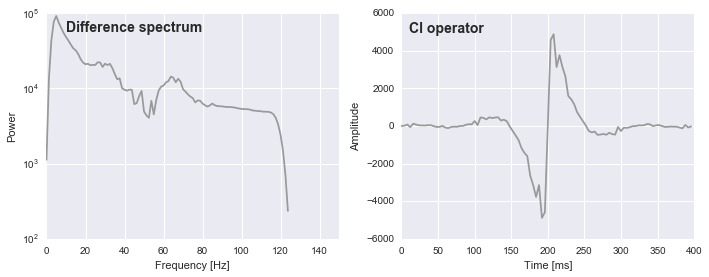

In [30]:
fig,(ax1,ax2) = plt.subplots(figsize=(10,4), ncols=2)
ax1.plot(freq_seis, np.abs(gap))
ax1.set_ylabel('Power')
ax1.set_xlabel('Frequency [Hz]')
ax1.text(10, 57000, 'Difference spectrum', fontsize=14, fontweight='semibold')
ax1.set_yscale('log')
ax1.set_xlim([0, 150])
ax1.set_ylim([100, 100000])

ax2.plot(np.arange(0, len(operator)*4, 4), operator)
ax2.text(10, 5000, 'CI operator', fontsize=14, fontweight='semibold')
ax2.set_xlabel('Time [ms]')
ax2.set_ylabel('Amplitude')
fig.tight_layout()
plt.show()

Here we plot the different steps from the gap to the final operator:

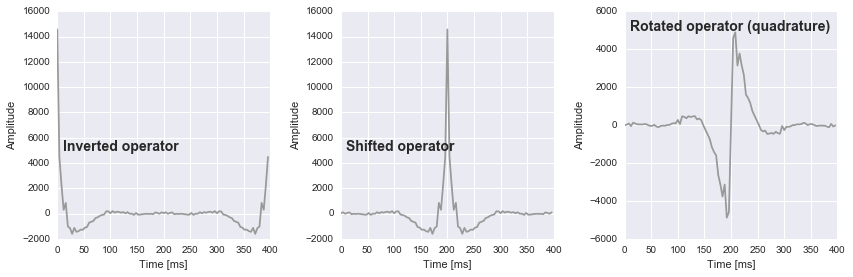

In [31]:
fig,(ax1,ax2,ax3) = plt.subplots(figsize=(12,4), ncols=3)

ax1.plot(np.arange(0, len(operator1)*4, 4), operator1.real)
ax1.text(10, 5000, 'Inverted operator', fontsize=14, fontweight='semibold')
ax1.set_xlabel('Time [ms]')
ax1.set_ylabel('Amplitude')

ax2.plot(np.arange(0, len(operator2)*4, 4), operator2.real)
ax2.text(10, 5000, 'Shifted operator', fontsize=14, fontweight='semibold')
ax2.set_xlabel('Time [ms]')
ax2.set_ylabel('Amplitude')

ax3.plot(np.arange(0, len(operator2.T)*4, 4), operator)
ax3.text(10, 5000, 'Rotated operator (quadrature)', fontsize=14, fontweight='semibold')
ax3.set_xlabel('Time [ms]')
ax3.set_ylabel('Amplitude')

fig.tight_layout()
plt.show()

## Step 4. Convolve the stacked seismic with the operator

To take advantage of NumPy's `apply_along__axis` (which is more elegant than a loop but not necessarily faster), we define a convolution function:

In [32]:
def convolve(t):
    return np.convolve(t, operator, mode='same')

Then apply it along the axis:

In [33]:
ci = np.apply_along_axis(convolve, axis=0, arr=panel_seis)

And plot the result! This is our coloured inversion:

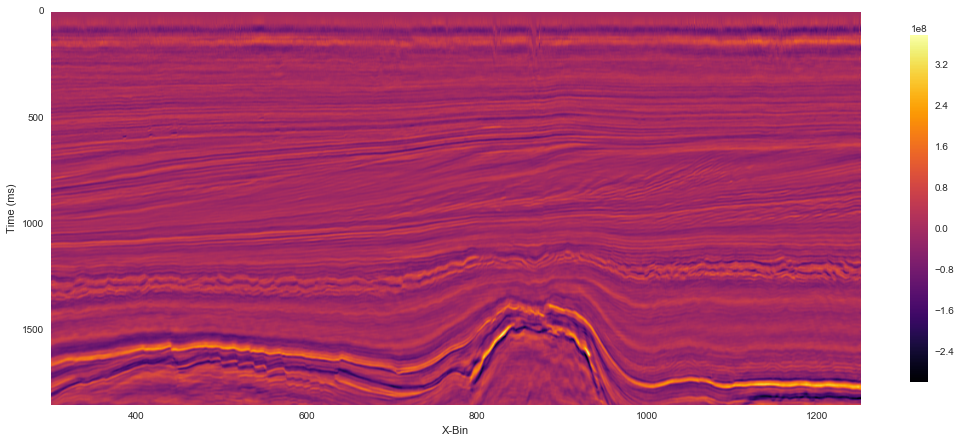

In [34]:
with sns.axes_style("dark"):
    fig,(ax) = plt.subplots(figsize=(15,10))
    extent = [np.min(xbin), np.max(xbin), np.max(time), np.min(time)]
    image=ax.imshow(ci, extent=extent, aspect=0.25, cmap="inferno", interpolation='bilinear')
    ax.set_xlabel('X-Bin')
    ax.set_ylabel('Time (ms)')
    ax.set_ylim(np.max(time), np.min(time))
    ax.set_xlim(np.min(xbin), np.max(xbin))
    cbar = plt.colorbar(image, shrink=0.5)
    fig.tight_layout()
    plt.show()

Now let's plot the result from the stratigraphic zone we were interested in:

In [35]:
idx = (time >= win_up) & (time <= win_down)

In [36]:
IP_CI = pd.DataFrame()
IP_CI['X'] = xi.ravel()
IP_CI['t'] = ti.ravel()
IP_CI['IP_relative'] = ci[idx].ravel()
IP_CI.loc[id_nan, 'IP_relative'] = np.nan
IP_CI['IP_scaled'] = (np.max(IP_CI.IP_relative) - IP_CI.IP_relative) / \
                     (np.max(IP_CI.IP_relative) - np.min(IP_CI.IP_relative))
IP_CI = IP_CI.set_index(['X', 't'])
IP_CI = IP_CI.unstack(level='X')

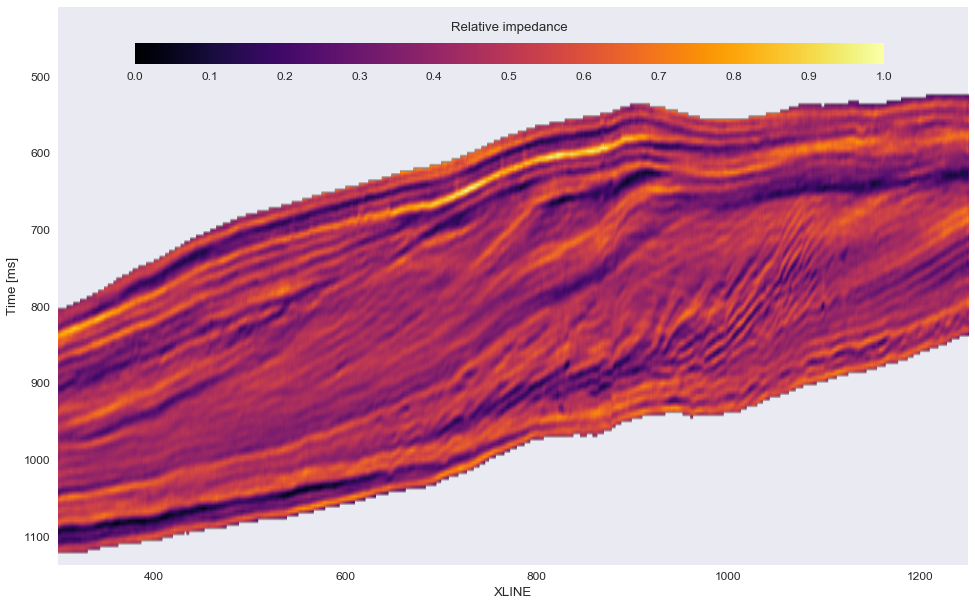

In [37]:
sns.set(font_scale=1.2)
with sns.axes_style("dark"):
    fig,(ax) = plt.subplots(figsize=(20, 10))
    extent = [np.min(xbin), np.max(xbin), np.max(time_IP), np.min(time_IP)]
    image=ax.imshow(IP_CI.IP_scaled, extent=extent, cmap='inferno', label='big', aspect=0.8)
    ax.set_ylim(np.max(time_IP), np.min(time_IP))
    ax.set_xlim(np.min(xbin), np.max(xbin))
    ax.set_xlabel('XLINE')
    ax.set_ylabel('Time [ms]')
    cax = fig.add_axes([0.25, 0.82, 0.52, 0.03])
    cbar = plt.colorbar(image, cax=cax, orientation='horizontal')
    cbar.set_label(label='Relative impedance', labelpad=-60)
    plt.show()

## Step 5. QC: compare log and AI section spectrums

Checking correspondance between CI power spectrum and the one modelled from the log

1. We calculate a mean AI trace from a buffer zone collocated with the log
2. We do the fft computation
3. We plot the scaled result

In [38]:
AI_trace = np.mean(ci[xmin:xmax, min_time:max_time], axis=0)

In [39]:
spec_AI = np.fft.fft(AI_trace) / n_seis # fft computing and normalization
spec_AI = spec_AI[range(n_seis//2)]
roll_win = np.ones(10) / 10
spec_AI = np.convolve(spec_AI, roll_win, mode='same')

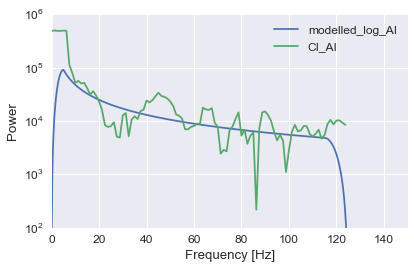

In [40]:
fig,ax = plt.subplots(figsize =(6,4))
ax.plot(new_freq_log, new_spec_log)
ax.set_ylabel('Power')
ax.set_xlabel('Frequency [Hz]')
ax.plot(freq_seis,np.abs((spec_AI)/4))  # 4 is a scaling factor.
# ax.set_title('Compared Spectra')
ax.set_yscale('log')
ax.set_xlim([0, 150])
ax.set_ylim([100, 1000000])
plt.legend(['modelled_log_AI', 'CI_AI'], loc='best')
plt.tight_layout()
plt.show()

<hr>

© Martin Blouin and Erwan Gloaguen, licensed CC-BY-SA